# Initialize Notebook
<hr style="border: none; height: 5px; background-color: white; margin-top: 0px; margin-bottom: 0px;">

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
import ROOT
import uproot
import os
import sys
import tqdm
import pandas as pd
import pickle as pkl

%jsroot on
# %matplotlib qt
%matplotlib inline

Welcome to JupyROOT 6.30/02


In [2]:
sys.path.append('../python/')
from filterMethods import *
from trackReconstructionMethods import *
from hitAccuracyMethods import *
from statisticsMethods import *
from importMethods import *
from constants import *
import plotParameters

In [3]:
sys.path.append("../")
import plotParameters

# Load Data
<hr style="border: none; height: 5px; background-color: white; margin-top: 0px; margin-bottom: 0px;">

In [4]:
# file_input_name = '../runs/calibration/calibration_-0.85000_-0.85000_-0.85000.root'
# file_input_name = '../runs/calibration/calibration_-0.85000_-0.85000_-0.85000.root'
# file_input_name = '../runs/calibration/calibration.root'
# file_input_name = '../runs/calibration_8x8x8_e-_5MeV/calibration.root'
# file_input_name = '../runs/output_NEST_e-_1MeV.root'
# file_input_name = '../build/event_total.root'
# file_input_name = '../build/event.root'
# file_input_name = '../build/output.root'
# file_input_name = '../runs/calorimeterSizes/0cm_calibration.root'
file_input_name = '../build/calibration.root'
histogram_directory = 'photoSensor_hits_histograms'
file_input_pyroot = ROOT.TFile(file_input_name)
file_input_uproot = uproot.open(file_input_name)

histogram_names = [name for name in file_input_uproot.keys() if "/photoSensor_" in name]
print(histogram_names)

histogram_titles = [file_input_pyroot.Get(name).GetTitle() for name in histogram_names]
print(histogram_titles)

histogram_positions = [(float(title.split('_')[2]), float(title.split('_')[3]), float(title.split('_')[4])) for title in histogram_titles]
print(histogram_positions)

tree_names = [name for name in file_input_uproot.keys() if histogram_directory not in name]
print(tree_names)

['photoSensor_hits_histograms/photoSensor_0;1', 'photoSensor_hits_histograms/photoSensor_1;1', 'photoSensor_hits_histograms/photoSensor_2;1', 'photoSensor_hits_histograms/photoSensor_3;1', 'photoSensor_hits_histograms/photoSensor_4;1', 'photoSensor_hits_histograms/photoSensor_5;1', 'photoSensor_hits_histograms/photoSensor_6;1', 'photoSensor_hits_histograms/photoSensor_7;1', 'photoSensor_hits_histograms/photoSensor_8;1', 'photoSensor_hits_histograms/photoSensor_9;1', 'photoSensor_hits_histograms/photoSensor_10;1', 'photoSensor_hits_histograms/photoSensor_11;1', 'photoSensor_hits_histograms/photoSensor_12;1', 'photoSensor_hits_histograms/photoSensor_13;1', 'photoSensor_hits_histograms/photoSensor_14;1', 'photoSensor_hits_histograms/photoSensor_15;1', 'photoSensor_hits_histograms/photoSensor_16;1', 'photoSensor_hits_histograms/photoSensor_17;1', 'photoSensor_hits_histograms/photoSensor_18;1', 'photoSensor_hits_histograms/photoSensor_19;1', 'photoSensor_hits_histograms/photoSensor_20;1', '

In [5]:
tree = file_input_uproot['photoSensor_hits;1']
data = {
    'position_initial': list(zip(
        tree['photoSensor_hits_position_initial_x'].array(),
        tree['photoSensor_hits_position_initial_y'].array(),
        tree['photoSensor_hits_position_initial_z'].array()
    )),
    'position_absolute': list(zip(
        tree['photoSensor_hits_position_absolute_x'].array(),
        tree['photoSensor_hits_position_absolute_y'].array(),
        tree['photoSensor_hits_position_absolute_z'].array()
    )),
    'process': tree['photoSensor_hits_process'].array(),
    'wall': tree['photoSensor_hits_photoSensorID'].array()
}

df_photoSensor_hits = pd.DataFrame(data)

df_photoSensor_hits['wall'] = df_photoSensor_hits['wall'].apply(lambda x: x.split('_')[1])
df_photoSensor_hits['position_delta'] = [np.array(pi) - np.array(pa) for pi, pa in zip(df_photoSensor_hits['position_initial'], df_photoSensor_hits['position_absolute'])]
df_photoSensor_hits['position_delta_r'] = np.linalg.norm(np.array(df_photoSensor_hits['position_delta'].tolist()), axis=1)

In [6]:
tree = file_input_uproot['calorimeter_hits;1']
data_calorimeter = {
    'position_initial': list(zip(
        tree['calorimeter_hits_position_initial_x'].array(),
        tree['calorimeter_hits_position_initial_y'].array(),
        tree['calorimeter_hits_position_initial_z'].array()
    )),
    'position_absolute': list(zip(
        tree['calorimeter_hits_position_absolute_x'].array(),
        tree['calorimeter_hits_position_absolute_y'].array(),
        tree['calorimeter_hits_position_absolute_z'].array()
    )),
    'process': tree['calorimeter_hits_process'].array(),
    'wall': tree['calorimeter_hits_calorimeterID'].array()
}

df_calorimeter_hits = pd.DataFrame(data_calorimeter)

df_calorimeter_hits['wall'] = df_calorimeter_hits['wall'].apply(lambda x: x.split('_')[2])
df_calorimeter_hits['position_delta'] = [np.array(pi) - np.array(pa) for pi, pa in zip(df_calorimeter_hits['position_initial'], df_calorimeter_hits['position_absolute'])]
df_calorimeter_hits['position_delta_r'] = np.linalg.norm(np.array(df_calorimeter_hits['position_delta'].tolist()), axis=1)

In [7]:
tree = file_input_uproot['lens_hits;1']
data_lens = {
    'position_initial': list(zip(
        tree['lens_hits_position_initial_x'].array(),
        tree['lens_hits_position_initial_y'].array(),
        tree['lens_hits_position_initial_z'].array()
    )),
    'position_absolute': list(zip(
        tree['lens_hits_position_absolute_x'].array(),
        tree['lens_hits_position_absolute_y'].array(),
        tree['lens_hits_position_absolute_z'].array()
    )),
    'process': tree['lens_hits_process'].array(),
    'transmittance': tree['lens_hits_transmittance'].array(),
    'wall': tree['lens_hits_lensID'].array()
}

df_lens_hits = pd.DataFrame(data_lens)

df_lens_hits = df_lens_hits[df_lens_hits['transmittance'] != True]
df_lens_hits['wall'] = df_lens_hits['wall'].apply(lambda x: x.split('_')[1])
df_lens_hits['position_delta'] = [np.array(pi) - np.array(pa) for pi, pa in zip(df_lens_hits['position_initial'], df_lens_hits['position_absolute'])]
df_lens_hits['position_delta_r'] = np.linalg.norm(np.array(df_lens_hits['position_delta'].tolist()), axis=1)

In [9]:
tree = file_input_uproot['medium_hits;1']
data_medium = {
    'position_initial': list(zip(
        tree['medium_hits_position_initial_x'].array(),
        tree['medium_hits_position_initial_y'].array(),
        tree['medium_hits_position_initial_z'].array()
    )),
    'position_absolute': list(zip(
        tree['medium_hits_position_absolute_x'].array(),
        tree['medium_hits_position_absolute_y'].array(),
        tree['medium_hits_position_absolute_z'].array()
    )),
    # 'process': tree['medium_hits_process'].array(),
    'transmittance': tree['medium_hits_transmittance'].array()
}

df_medium_hits = pd.DataFrame(data_medium)

print('number transmitted:', len(df_medium_hits[df_medium_hits['transmittance'] == True]))
print('number reflected  :', len(df_medium_hits[df_medium_hits['transmittance'] == False]))

df_medium_hits = df_medium_hits[df_medium_hits['transmittance'] != True]

df_medium_hits['position_delta'] = [np.array(pi) - np.array(pa) for pi, pa in zip(df_medium_hits['position_initial'], df_medium_hits['position_absolute'])]
df_medium_hits['position_delta_r'] = np.linalg.norm(np.array(df_medium_hits['position_delta'].tolist()), axis=1)

In [12]:
tree = file_input_uproot['photon;1']
data_photon = {
    'photon_stepNumber': tree['photon_stepNumber'].array(),
}

df_photon = pd.DataFrame(data_photon)
print(len(df_photon))

In [13]:
wall = '+x'
df_photoSensor_hits = df_photoSensor_hits[df_photoSensor_hits['wall'] == wall]
df_calorimeter_hits = df_calorimeter_hits[df_calorimeter_hits['wall'] == wall]
df_lens_hits = df_lens_hits[df_lens_hits['wall'] == wall]

# Plot Data
<hr style="border: none; height: 5px; background-color: white; margin-top: 0px; margin-bottom: 0px;">

In [ ]:
nPhotons_total = np.sum(df_photon['photon_stepNumber'].values == 1)
nPhotons_calorimeter = len(df_calorimeter_hits)
nPhotons_photoSensor = len(df_photoSensor_hits)
nPhotons_lens        = len(df_lens_hits)
nPhotons_medium      = len(df_medium_hits)

print("nPhotons_total      : ", nPhotons_total)
print("nPhotons_calorimeter: ", nPhotons_calorimeter)
print("nPhotons_photoSensor: ", nPhotons_photoSensor)
print("nPhotons_lens       : ", nPhotons_lens)
print("nPhotons_medium     : ", nPhotons_medium)
print("sum(volumes)        : ", nPhotons_calorimeter + nPhotons_photoSensor + nPhotons_lens + nPhotons_medium)
print('sum(volumes) / nPhotons_total: ', (nPhotons_calorimeter + nPhotons_photoSensor + nPhotons_lens + nPhotons_medium) / nPhotons_total)

nPhotons_total      :  10000000
nPhotons_calorimeter:  650681
nPhotons_photoSensor:  2020
nPhotons_lens       :  180
nPhotons_medium     :  9347119
sum(volumes)        :  10000000
sum(volumes) / nPhotons_total:  1.0


In [ ]:
nBins = 50
scale = 10

hist_total, bins_total = np.histogram(np.concatenate((df_calorimeter_hits['position_delta_r'],
                                                      df_photoSensor_hits['position_delta_r'],
                                                      df_lens_hits       ['position_delta_r'],
                                                      df_medium_hits     ['position_delta_r'])), bins=nBins)
hist_total = np.append(hist_total, 0)
bins_total = np.append(bins_total, bins_total[-1]+(bins_total[1]-bins_total[0]))

weights_calorimeter = np.array([
    1/hist_total[np.digitize(c, bins_total)-1] 
    if hist_total[np.digitize(c, bins_total)-1] != 0 else 0 
    for c in df_calorimeter_hits['position_delta_r']
])
weights_photoSensor = np.array([
    1/hist_total[np.digitize(c, bins_total)-1]
    if hist_total[np.digitize(c, bins_total)-1] != 0 else 0
    for c in df_photoSensor_hits['position_delta_r']
])
weights_lens = np.array([
    1/hist_total[np.digitize(c, bins_total)-1]
    if hist_total[np.digitize(c, bins_total)-1] != 0 else 0
    for c in df_lens_hits['position_delta_r']
])
weights_medium = np.array([
    1/hist_total[np.digitize(c, bins_total)-1]
    if hist_total[np.digitize(c, bins_total)-1] != 0 else 0
    for c in df_medium_hits['position_delta_r']
])

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_44599/1595947813.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


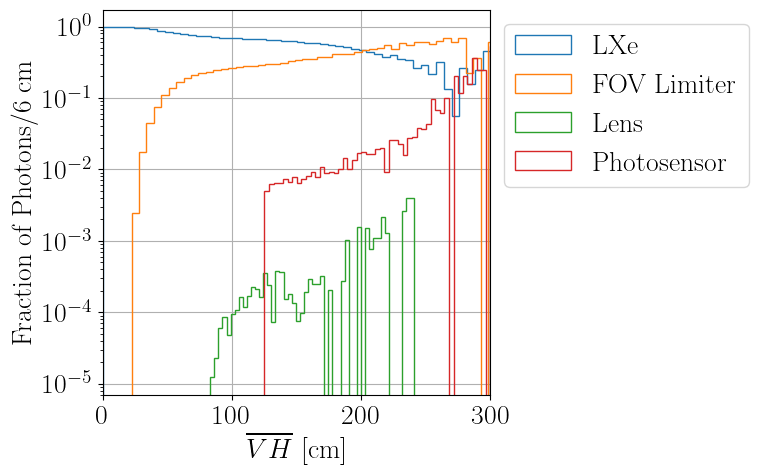

In [ ]:

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(df_medium_hits     ['position_delta_r']/scale, bins=nBins, weights=weights_medium     , label='LXe'        , histtype='step')
ax.hist(df_calorimeter_hits['position_delta_r']/scale, bins=nBins, weights=weights_calorimeter, label='FOV Limiter', histtype='step')
ax.hist(df_lens_hits       ['position_delta_r']/scale, bins=nBins, weights=weights_lens       , label='Lens'       , histtype='step')
ax.hist(df_photoSensor_hits['position_delta_r']/scale, bins=nBins, weights=weights_photoSensor, label='Photosensor', histtype='step')
ax.set_xlabel(r'$\overline{VH}$ [cm]')
ax.set_ylabel(r'Fraction of Photons/6 cm')
ax.set_xlim(xmin=0, xmax=300)
# ax.set_ylim(ymin=0)
ax.set_yscale('log')
# ax.text(0.99, 0.99, '60 cm', transform=ax.transAxes, ha='right', va='top', size=25)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.grid()
# fig.savefig('../figures/transmittance_60cm_nolegend_v3.pdf', bbox_inches='tight')
fig.show()
